<a href="https://colab.research.google.com/github/Adrian-Muino/DMML2022_Geneva/blob/main/Colab_Notebooks/4.DMML_2022_Geneva_Bert%26Tensor_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A. Introduction


blabla à écrire

#B. Prerequisites

##Installations

In [1]:
#Installation
!pip install sentence-transformers
!python -m spacy download fr_core_news_sm
!python -m spacy link fr_core_news_sm fr
!python -m spacy download fr_core_news_md
!pip install tensorflow_hub
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2022-12-21 10:00:44.189682: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-21 10:00:46.746690: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-21 10:00:46.746983: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could no

##Imports

In [2]:
# Imports the functions we use all along our projects that are in python file in our GitHub
import requests
url = 'https://raw.githubusercontent.com/Adrian-Muino/DMML2022_Geneva/main/Colab_Notebooks/dmml_2022_geneva_functions.py'

r = requests.get(url)

with open('dmml_2022_geneva_functions.py', 'w') as f:
    f.write(r.text)

In [3]:
# All the other imports
import string
import re

from dmml_2022_geneva_functions import *
import pandas as pd

import spacy
from spacy import displacy

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
nltk.download('punkt')

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from keras import backend as K

from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier, Perceptron
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils.multiclass import unique_labels
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#C. Environment set up & exploratory data analysis

In [4]:
# load the data from our github repository
training_data = 'https://raw.githubusercontent.com/Adrian-Muino/DMML2022_Geneva/main/Data/training_data.csv'
unlabelled_data = 'https://raw.githubusercontent.com/Adrian-Muino/DMML2022_Geneva/main/Data/unlabelled_test_data.csv'

df = df_train = pd.read_csv(training_data)
df_unlabeled = df_test = pd.read_csv(unlabelled_data)

#D. Bert & Tensor Model

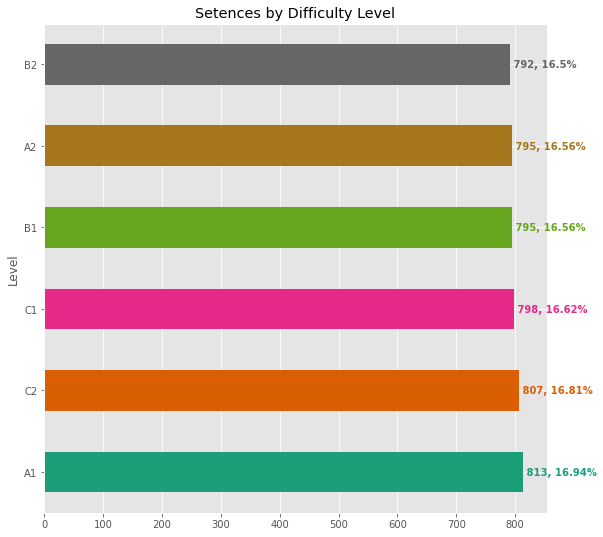

In [5]:
plt.style.use('ggplot')

num_classes = len(df["difficulty"].value_counts())

colors = plt.cm.Dark2(np.linspace(0, 1, num_classes))
iter_color = iter(colors)

df['difficulty'].value_counts().plot.barh(title="Setences by Difficulty Level", 
                                                 ylabel="Level",
                                                 color=colors,
                                                 figsize=(9,9))

for i, v in enumerate(df['difficulty'].value_counts()):
  c = next(iter_color)
  plt.text(v, i,
           " "+str(v)+", "+str(round(v*100/df.shape[0],2))+"%", 
           color=c, 
           va='center', 
           fontweight='bold')

In [6]:
# map topic descriptions to labels
df['Level'] = df['difficulty'].map({'A1': 0,
                                    'A2': 1,
                                    'B1': 2,
                                    'B2': 3,
                                    'C1': 4,
                                    'C2': 5,})

# drop unused column
df = df.drop(["difficulty"], axis=1)

df.head()

,id,sentence,Level
0,0,Les coûts kilométriques réels peuvent diverger...,4
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",0
2,2,Le test de niveau en français est sur le site ...,0
3,3,Est-ce que ton mari est aussi de Boston?,0
4,4,"Dans les écoles de commerce, dans les couloirs...",2


In [7]:
y = tf.keras.utils.to_categorical(df["Level"].values, num_classes=num_classes)

x_train, x_test, y_train, y_test = train_test_split(df['sentence'], y, test_size=0.01)

In [8]:

preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")

#function imported
get_embeddings([
    "Les coûts kilométriques réels peuvent diverger sensiblement des valeurs moyennes en fonction du moyen de transport utilisé, du taux d'occupation ou du taux de remplissage, de l'infrastructure utilisée, de la topographie des lignes, du flux de trafic, etc."]
)

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-3.63910258e-01,  2.15398788e-01, -5.70777714e-01,
        -4.57451105e-01,  1.94023758e-01, -3.41217995e-01,
        -4.04713154e-02, -2.72382319e-01, -2.03393221e-01,
         4.53949682e-02, -7.60403693e-01, -3.80386680e-01,
         5.12294844e-02, -3.07878345e-01, -6.63932443e-01,
        -3.10593396e-01, -1.94574539e-02, -3.24811250e-01,
         9.24876519e-03, -6.82701245e-02,  4.39894527e-01,
         1.90011024e-01, -1.96524307e-01,  3.22621018e-01,
        -2.80327387e-02, -9.78578866e-01,  2.13872176e-02,
        -7.58466840e-01, -3.53789419e-01, -4.06974137e-01,
         2.11517617e-01, -6.07399881e-01, -3.57876688e-01,
        -4.86233175e-01, -5.95954418e-01,  4.41090241e-02,
        -2.92998347e-02,  2.86389410e-01, -5.22589028e-01,
         5.57419479e-01, -1.57448128e-01, -3.20106894e-01,
        -4.56426799e-01,  3.34122181e-01,  1.46670938e-02,
         3.74397077e-02, -1.25980809e-01, -2.15156108e-01,
      

In [9]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [10]:
n_epochs = 20

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)



model_fit = model.fit(x_train, 
                      y_train, 
                      epochs = n_epochs,
                      validation_data = (x_test, y_test),
                      callbacks = [earlystop_callback])

Epoch 1/20
 88/149 [================>.............] - ETA: 13:50 - loss: 1.5856 - accuracy: 0.3093 - balanced_recall: 0.0458 - balanced_precision: 0.1204 - balanced_f1_score: 0.0632

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-78962f886f78>", line 20, in <module>
    model_fit = model.fit(x_train,
  File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1650, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 880, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_fu

KeyboardInterrupt: ignored

In [ ]:
#function imported
predict_class(df_unlabeled["sentence"])

In [ ]:
predictions_to_submit = pd.DataFrame(predict_class(df_unlabeled["sentence"]))
predictions_to_submit.columns = ['difficulty']

In [ ]:
predictions_to_submit

In [ ]:
predictions_to_submit['difficulty'] = predictions_to_submit['difficulty'].map({0: "A1",
                                    1: 'A2',
                                    2: 'B1',
                                    3: 'B2',
                                    4: 'C1',
                                    5: 'C2'})
predictions_to_submit = predictions_to_submit.rename_axis("id")
predictions_to_submit

In [ ]:
predictions_to_submit.to_csv("Geneva_predictions_BertTensor4.csv")